In [23]:
import sys
sys.path.append('generate_data')
from generator import *
import pandas as pd

<h4>The task involves developing a data pipeline to complete the user story above using sample data
sources that will be provided.<br><br>
Our data science team has reached out to our data engineering team requesting we pre-process
some of the data for them at scale so that they can make better use of it in their downstream
algorithms.<br><br>
The input data sources are comprised of customers (in CSV format), transactions (in JSON Lines
format) and products (in CSV format). Their details are presented below</h4>

### Loading data

##### Customers

In [24]:
df_customers = read_csv(os.path.join(output_location, 'customers.csv'))
df_customers.head()

,customer_id,loyalty_score
0,C1,7
1,C2,4
2,C3,13
3,C4,11
4,C5,8


In [25]:
df_customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137 entries, 0 to 136
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customer_id    137 non-null    object
 1   loyalty_score  137 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.3+ KB


In [26]:
print('Всего строк:', len(df_customers))
print('Количество дубликатов:', df_customers.duplicated().sum())
print('Уникальных пользователей:', df_customers['customer_id'].nunique())

Всего строк: 137
Количество дубликатов: 0
Уникальных пользователей: 137


##### Products

In [27]:
df_products = read_csv(os.path.join(output_location, 'products.csv'))
df_products.head()

,product_id,product_description,product_category
0,P01,detergent,house
1,P02,kitchen roll,house
2,P03,bin liners,house
3,P04,shower gel,house
4,P05,scented candles,house


In [28]:
print('Всего строк:', len(df_products))
print('Количество дубликатов:', df_products.duplicated().sum())
print('Уникальных категорий продуктов:', df_products['product_category'].nunique())
print(df_products['product_category'].unique())

Всего строк: 64
Количество дубликатов: 0
Уникальных категорий продуктов: 6
['house' 'clothes' 'fruit_veg' 'sweets' 'food' 'bws']


##### Transactions

In [29]:
df_transactions = read_json_folder(os.path.join(output_location, 'transactions',''))
df_transactions.head()

,customer_id,basket,date_of_purchase
0,C2,"[{'product_id': 'P31', 'price': 909}]",2023-04-10 12:19:05.976681
1,C3,"[{'product_id': 'P32', 'price': 382}, {'produc...",2023-04-10 07:08:05.976681
2,C6,"[{'product_id': 'P13', 'price': 1060}, {'produ...",2023-04-09 22:05:05.976681
3,C13,"[{'product_id': 'P35', 'price': 1416}, {'produ...",2023-04-10 07:36:05.976681
4,C15,"[{'product_id': 'P34', 'price': 761}]",2023-04-10 12:43:05.976681


In [30]:
df_transactions.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2445 entries, 0 to 25
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customer_id       2445 non-null   object
 1   basket            2445 non-null   object
 2   date_of_purchase  2445 non-null   object
dtypes: object(3)
memory usage: 76.4+ KB


In [31]:
print('Всего строк:', len(df_transactions))
print('Уникальных клиеннтов:', df_transactions['customer_id'].nunique())
print(df_transactions['customer_id'].nunique() == df_customers['customer_id'].nunique())

Всего строк: 2445
Уникальных клиеннтов: 137
True


In [32]:
# вытаскиваем значения `product_id` из списка словарей для каждого клиента

from ast import literal_eval

df_transactions['basket'] = df_transactions['basket'].apply(str).apply(literal_eval)
df_transactions['products'] = df_transactions['basket'].apply(lambda x: 
                                                                [elm['product_id'] for elm in x])

df_transactions.sample(2)

,customer_id,basket,date_of_purchase,products
23,C111,"[{'product_id': 'P23', 'price': 1807}, {'produ...",2023-05-08 02:54:05.976681,"[P23, P24]"
19,C86,"[{'product_id': 'P39', 'price': 226}, {'produc...",2023-04-09 23:44:05.976681,"[P39, P36, P37]"


In [36]:
from collections import Counter

# группируем транзакции по клиентам
tmp = df_transactions.groupby('customer_id').agg({'products': sum}).reset_index()
print('Уникальных клиеннтов:', len(tmp))

#  считаем количество купленных продуктов для каждого `product_id`
tmp['product_cnt'] = tmp['products'].apply(lambda x: Counter(x))
tmp['product_id'] = tmp['product_cnt'].apply(lambda x: [k for k in x])
tmp['purchaise_count'] = tmp['product_cnt'].apply(lambda x: [v for v in x.values()])

# создаеем вспомогательный столбец для проверки результатов объединения
tmp['len'] = tmp['product_cnt'].apply(len)
print('Общее количество купленных продуктов:', tmp['len'].sum())

Уникальных клиеннтов: 137
Общее количество купленных продуктов: 2323


In [12]:
# готовим основу итогового датасета: удаляем лишнее и разбиваем продукты по позициям для каждого клиента

df = (tmp.drop(['products', 'product_cnt', 'len'], axis=1)
               .explode(['product_id', 'purchaise_count']).reset_index(drop=True))
print('Длина итогового датасета:', df.shape[0])
print(tmp['len'].sum() == df.shape[0])
df.head(3)

Длина итогового датасета: 2323
True


,customer_id,product_id,purchaise_count
0,C1,P37,16
1,C1,P40,15
2,C1,P38,8


In [13]:
# присоединяем информацию о категории продуктов и пользователях

df = pd.merge(df, df_products.drop('product_description', axis=1), on='product_id', how='left')
df = pd.merge(df, df_customers, on='customer_id', how='left')

cols = ['customer_id', 'loyalty_score', 'product_id', 'product_category', 'purchaise_count']
df = df[cols].copy()
print(df.shape)
df.head(3)

(2323, 5)


,customer_id,loyalty_score,product_id,product_category,purchaise_count
0,C1,7,P37,sweets,16
1,C1,7,P40,sweets,15
2,C1,7,P38,sweets,8


Проверям, все ли сходится:

In [15]:
tmp  = (df.groupby(['customer_id', 'loyalty_score'])
            .agg({'customer_id': 'nunique'})
            .rename(columns={'customer_id': 'id_cnt'})
            .reset_index()
            )

Counter(tmp['loyalty_score'].to_list()) == Counter(df_customers['loyalty_score'].to_list()) 

True

In [16]:
df_customers.sort_values('customer_id').reset_index()

,index,customer_id,loyalty_score
0,0,C1,7
1,9,C10,3
2,99,C100,14
3,100,C101,7
4,101,C102,12
...,...,...,...
132,94,C95,10
133,95,C96,14
134,96,C97,4
135,97,C98,14


In [17]:
df.groupby(['customer_id', 'loyalty_score']).agg({'customer_id': [('tmp', 'nunique')]}).reset_index()

,customer_id,loyalty_score,customer_id
,,,tmp
0,C1,7,1
1,C10,3,1
2,C100,14,1
3,C101,7,1
4,C102,12,1
...,...,...,...
132,C95,10,1
133,C96,14,1
134,C97,4,1


Я вытащила покупки из `df_transactions`, сгруппировала их по пользователям и посчитала количество для каждого типа продукта. Затем вновь разбила их, чтобы присоединить категории продукта и данные о лояльности пользователей. 

Для передачи данных я написала скрипт с пайплайном `customers_transactions.py`, который сохраняет итоговый датасет в формте `.csv`.

In [19]:
# # получившийся датасет можно сохранить в нужном формате, например .csv и передать в DS.

# import os

# output_data = './output_data'
# os.makedirs(output_data, exist_ok=True)

# df.to_csv(os.path.join(output_data, 'customer_products_purchase.csv'), index=False)

In [37]:
# df = pd.read_csv(os.path.join(output_data, 'customer_products_purchase.csv'))
# df.head()

,customer_id,loyalty_score,product_id,product_category,purchaise_count
0,C1,7,P37,sweets,16
1,C1,7,P40,sweets,15
2,C1,7,P38,sweets,8
3,C1,7,P35,sweets,9
4,C1,7,P39,sweets,8


### Task from Data Scientist

As a data scientist I want to be able to consume a data source that
contains information about how many times each of our customers
buys our products in a given period, so that I can predict what they
will buy next


The output data source should contain information for every customer that has the following
fields:

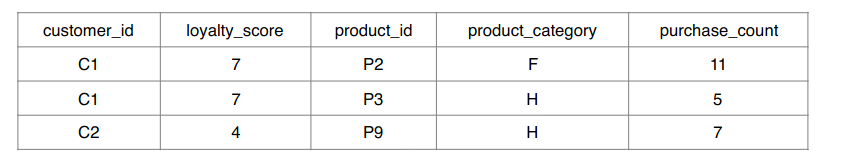